출처 : [Weather Classification | Kaggle](https://www.kaggle.com/nishanthnarayanan/weather-classification)

In [1]:
import os
for dirname, _, filenames in os.walk('dataset'):
        print(dirname)

dataset
dataset/cloudy
dataset/shine
dataset/sunrise
dataset/rainy
dataset/alien_test
dataset/foggy


In [2]:
import pandas as pd
import numpy as np

import random
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import matplotlib.pyplot as plt

In [3]:
base_dir = os.path.join("dataset/")
os.listdir(base_dir)

['cloudy', 'shine', 'test.csv', 'sunrise', 'rainy', 'alien_test', 'foggy']

In [4]:
train_dir = "train/"
test_dir = base_dir + "alien_test/"

In [ ]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
            
copytree(base_dir, train_dir)

In [6]:
for i in os.listdir(train_dir):
    if i not in ['sunrise', 'shine', 'cloudy', 'rainy', 'foggy']:
        try:
            os.remove(train_dir + i)
        except:
            shutil.rmtree(train_dir + i)

In [7]:
print("Train directory -->", os.listdir(train_dir))
print("Test directory -->", os.listdir(test_dir)[:5])

Train directory --> ['cloudy', 'shine', 'sunrise', 'rainy', 'foggy']
Test directory --> ['rain_3.jpg', 'sunrise_4.jpg', 'shine_1.jpg', 'rain_2.png', 'sunrise_5.jpg']


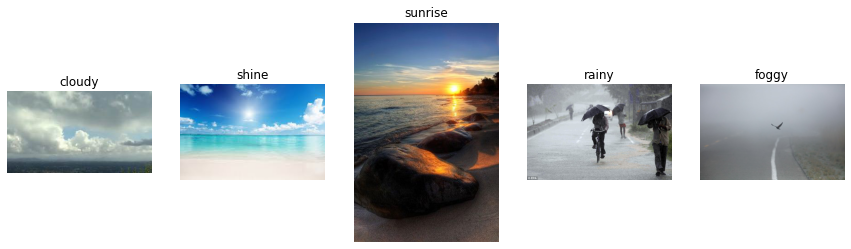

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i, folder in enumerate(os.listdir(train_dir)):
    sample_paper = random.choice(os.listdir(train_dir + folder))
    image = load_img(train_dir + folder + "/" + sample_paper)
    ax[i].imshow(image)
    ax[i].set_title(folder)
    ax[i].axis("Off")

In [9]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dense(5, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'SGD',
              metrics = ['accuracy'])

## Callback function

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.85):
            print("\nReached >85% accuracy so cancelling training!")
            self.model.stop_training = True
        
callbacks = myCallback()

## Image Generator

In [13]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.4, # Shifting image width by 40%
      height_shift_range=0.4,# Shifting image height by 40%
      shear_range=0.2,       # Rotation across X-axis by 20%
      zoom_range=0.3,        # Image zooming by 30%
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 20
)

Found 1500 images belonging to 5 classes.


In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = np.ceil(1500/20),  # 1500 images = batch_size * steps
      epochs = 1,
      callbacks=[callbacks],
      verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
75/75 - 24s - loss: 1.5486 - accuracy: 0.3547


In [15]:
print("Accuracy of the model on train data is {:.2f}%".format(history.history["accuracy"][-1]*100))

Accuracy of the model on train data is 35.47%


In [16]:
test_img = os.listdir(os.path.join(test_dir))

test_df = pd.DataFrame({'Image': test_img})
test_df.head()

,Image
0,rain_3.jpg
1,sunrise_4.jpg
2,shine_1.jpg
3,rain_2.png
4,sunrise_5.jpg


In [17]:
len(test_df)

30

### Test Generator

In [18]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col = 'Image',
    y_col = None,
    class_mode = None,
    target_size = (150, 150),
    batch_size = 20,
    shuffle = False
)

Found 30 validated image filenames.


In [19]:
predict = model.predict_generator(test_generator, steps = int(np.ceil(30/20)))

Instructions for updating:
Please use Model.predict, which supports generators.


#### Label Mapping

In [20]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

{0: 'cloudy', 1: 'foggy', 2: 'rainy', 3: 'shine', 4: 'sunrise'}

In [21]:
np.argmax(predict, axis = 1)

array([2, 4, 3, 4, 4, 4, 3, 3, 4, 1, 4, 2, 3, 4, 4, 2, 4, 1, 3, 1, 0, 3,
       1, 1, 2, 3, 4, 1, 1, 1])

In [22]:
test_df['Label'] = np.argmax(predict, axis = 1)
test_df['Label'] = test_df['Label'].replace(label_map)

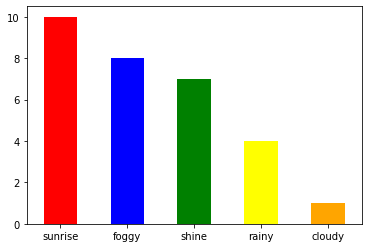

In [23]:
test_df.Label.value_counts().plot.bar(color = ['red','blue','green','yellow','orange'])
plt.xticks(rotation = 0)
plt.show()